### Descripción de las poses:

1. **`downdog` (Perro mirando hacia abajo)**  
   - **Descripción**: Manos y pies en el piso, formando un ángulo invertido con el cuerpo (pose típica del saludo al sol).  
   - **Postura clave**: Caderas elevadas y espalda recta.  

2. **`goddess` (Diosa)**  
   - **Descripción**: Piernas abiertas con las rodillas flexionadas, brazos extendidos hacia arriba al costado de la cabeza.  
   - **Postura clave**: Postura de fuerza y apertura.  

3. **`plank` (Plancha)**  
   - **Descripción**: Cuerpo recto en paralelo al suelo, apoyándose únicamente en las palmas de las manos y los dedos de los pies.  
   - **Postura clave**: Fuerte contracción del abdomen para mantener el equilibrio.  

4. **`tree` (Árbol)**  
   - **Descripción**: De pie en un solo pie, con las manos juntas frente al pecho o extendidas hacia arriba.  
   - **Postura clave**: Pierna elevada con el pie apoyado en el muslo interno contrario.  

5. **`warrior2` (Guerrero 2)**  
   - **Descripción**: Piernas abiertas con una rodilla flexionada y brazos extendidos en línea recta a los costados.  
   - **Postura clave**: Apertura del pecho y mirada hacia la mano delantera.  


## Librerias

In [1]:
!pip install mediapipe
!pip install fiftyone
!pip install fiftyone


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.1/36.1 MB 41.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of motor to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.7/74.7 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 39.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━

In [2]:
!pip install tensorflow


In [3]:
import cv2
import os
import numpy as np
import pandas as pd
import mediapipe as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import LabelEncoder
import requests




# Configuracion y preparacion del uso de MediaPipe Pose

In [144]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose()

In [145]:
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    print("Modelo Pose inicializado, listo para procesar imágenes.")


Modelo Pose inicializado, listo para procesar imágenes.


# 1 | Data Load

### Cargar archivos desde GitHub

In [247]:

repo_owner = 'brimoresco'
repo_name = 'cv-tp-yoga-moresco'
train_dir = 'TEST'
test_dir = 'TRAIN'
branch = 'main'

# Función para obtener el listado de archivos desde el repositorio de GitHub
def get_github_file_list(owner, repo, path, branch='main'):
    url = f'https://api.github.com/repos/{owner}/{repo}/contents/{path}?ref={branch}'
    response = requests.get(url)
    response.raise_for_status()  # Asegura que la solicitud sea exitosa
    files = response.json()
    return files




Como mi dataset se encuentra en un repositorio, y necesito descargar las imágenes desde URLs en tiempo real:

In [248]:
def load_image_from_url(url):
    resp = requests.get(url)
    img = np.array(bytearray(resp.content), dtype=np.uint8)
    img = cv2.imdecode(img, -1)
    if img is None:
        print(f"Error loading image from {url}")
    return img


###  Carga y procesamiento de datos

*interpolate_between_keypoints*

-Toma los keypoints y las conexiones (aristas) y genera puntos interpolados entre ellos.
- Añade estos puntos adicionales a la lista de keypoints para aumentar la cantidad de puntos en cada imagen.

In [249]:

def interpolate_between_keypoints(keypoints, edges, num_points=5):
    """
    Interpola nuevos puntos entre los keypoints conectados por las aristas.

    Parameters:
        keypoints (list): Lista de keypoints con formato [x, y, z].
        edges (list): Lista de tuplas con las conexiones de los keypoints (índices).
        num_points (int): Número de puntos a generar entre cada par de keypoints.

    Returns:
        list: Lista de keypoints con puntos interpolados.
    """
    interpolated_keypoints = []

    # Añadimos los puntos originales primero
    for i, keypoint in enumerate(keypoints):
        interpolated_keypoints.append(keypoint)

    # Para cada conexión entre keypoints (arista)
    for start_idx, end_idx in edges:
        start_keypoint = np.array(keypoints[start_idx])  # Punto de inicio de la arista
        end_keypoint = np.array(keypoints[end_idx])  # Punto final de la arista

        # Generamos los puntos interpolados entre estos dos keypoints
        for t in np.linspace(0, 1, num_points + 2)[1:-1]:  # Saltamos los extremos
            interpolated_keypoints.append((start_keypoint * (1 - t) + end_keypoint * t).tolist())

    return interpolated_keypoints

*data_loader_to_dataframe*

- Carga las imágenes desde las URLs proporcionadas por el repositorio de GitHub.
- Detecta los keypoints utilizando MediaPipe Pose.
- Interpola puntos adicionales entre las aristas (conexiones) de los keypoints.
- Almacena las imágenes, los keypoints aumentados y las etiquetas (poses) en un DataFrame.

In [250]:
import pandas as pd

def data_loader_to_dataframe(path, repo_owner, repo_name, num_points=5):
    """
    Carga los datos desde un repositorio, detecta keypoints, aplica interpolación y los almacena en un DataFrame.

    Parameters:
        path (str): Ruta base del conjunto de datos en el repositorio.
        repo_owner (str): Nombre del propietario del repositorio.
        repo_name (str): Nombre del repositorio.
        num_points (int): Número de puntos a interpolar entre cada par de keypoints.

    Returns:
        pd.DataFrame: DataFrame con columnas ['url_img', 'keypoints', 'pose_name'].
    """
    data = []  # Para almacenar datos estructurados como filas de un DataFrame
    pose = mp.solutions.pose.Pose()  # Objeto para detectar poses humanas
    s, f = 0, 0  # Contadores de éxito y fallo

    # Obtener la lista de etiquetas (carpetas de clase)
    labels = [item['name'] for item in get_github_file_list(repo_owner, repo_name, path)]

    for label in tqdm(labels):
        label_path = os.path.join(path, label)
        files = get_github_file_list(repo_owner, repo_name, label_path)  # Obtener archivos en la carpeta

        for file in files:
            image_url = file['download_url']  # URL cruda para descargar la imagen

            if image_url:
                img = load_image_from_url(image_url)
                if img is not None and img.size != 0:
                    # -------- pose detection -------
                    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    results = pose.process(img_rgb)
                    if results.pose_landmarks:
                        # Extraer los keypoints
                        keypoints = [
                            [lmk.x, lmk.y, lmk.z] for lmk in results.pose_landmarks.landmark
                        ]

                        # Obtener las conexiones de keypoints (aristas)
                        edges = list(mp.solutions.pose.POSE_CONNECTIONS)

                        # Aplicar interpolación
                        interpolated_keypoints = interpolate_between_keypoints(
                            keypoints, edges, num_points=num_points
                        )

                        # Añadir una fila al conjunto de datos con keypoints interpolados
                        data.append({
                            "url_img": image_url,
                            "keypoints": interpolated_keypoints,
                            "pose_name": label
                        })
                        s += 1
                    else:
                        f += 1
                else:
                    print(f"Error loading image from {image_url}")
            else:
                print(f"Invalid image URL: {image_url}")

    mode = path.split('/')[-1]
    print(f'{mode} total: success {s}, fail {f}')
    print(f"Data collected: {len(data)} items")

    return pd.DataFrame(data)




no solo aumenta la cantidad de datos, sino que también proporciona más información sobre las relaciones espaciales entre los keypoints.

In [251]:
# Crear los DataFrames de train y test
train_df = data_loader_to_dataframe(train_dir, repo_owner, repo_name, num_points=5)
test_df = data_loader_to_dataframe(test_dir, repo_owner, repo_name, num_points=5)



100%|██████████| 5/5 [02:30<00:00, 30.06s/it]


TEST total: success 440, fail 36
Data collected: 440 items


100%|██████████| 5/5 [05:11<00:00, 62.21s/it]

TRAIN total: success 970, fail 110
Data collected: 970 items


### Análisis Exploratorio

In [262]:
# Ver las primeras filas
train_df.head()


,url_img,keypoints,pose_name
0,https://raw.githubusercontent.com/brimoresco/c...,"[[0.5125513672828674, 0.7227011919021606, -0.0...",downdog
1,https://raw.githubusercontent.com/brimoresco/c...,"[[0.4308083653450012, 0.5596960783004761, -1.0...",downdog
2,https://raw.githubusercontent.com/brimoresco/c...,"[[0.4426484704017639, 0.4210481345653534, -0.9...",downdog
3,https://raw.githubusercontent.com/brimoresco/c...,"[[0.5500473380088806, 0.6354166865348816, -0.4...",downdog
4,https://raw.githubusercontent.com/brimoresco/c...,"[[0.3646571636199951, 0.7277389764785767, -0.0...",downdog


In [263]:

# Mostrar estadísticas descriptivas sobre las características
keypoints_len = train_df['keypoints'].apply(len)
print(f"Longitud de keypoints promedio: {keypoints_len.mean()}")
print(f"Longitud de keypoints por imagen: {keypoints_len.unique()}")


Longitud de keypoints promedio: 208.0
Longitud de keypoints por imagen: [208]


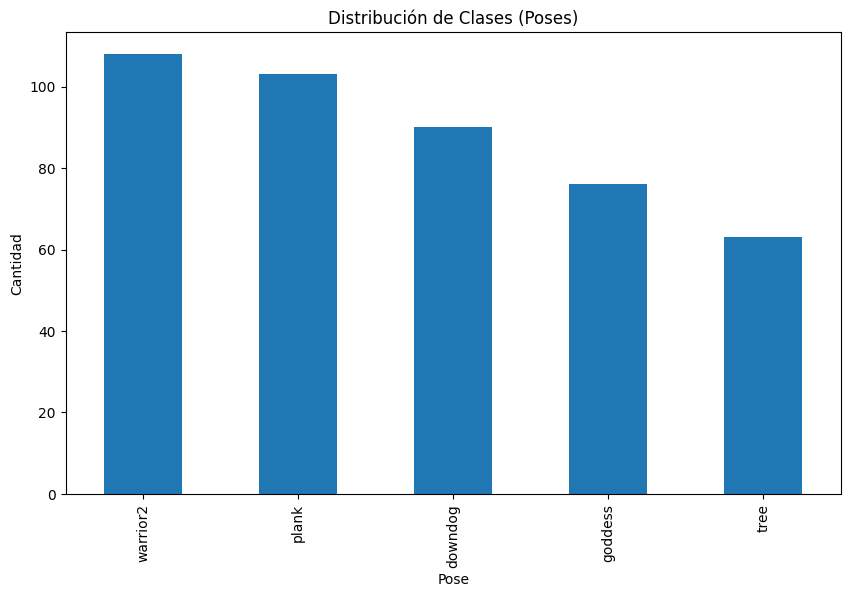

In [264]:


# Visualización de la distribución de las clases
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title("Distribución de Clases (Poses)")
plt.xlabel("Pose")
plt.ylabel("Cantidad")
plt.show()


In [265]:
# Ver la distribución de etiquetas en los conjuntos de datos
train_counts = pd.Series(train_df["pose_name"]).value_counts()
test_counts = pd.Series(test_df["pose_name"]).value_counts()

print("Distribución en el conjunto de entrenamiento:")
print(train_counts)

print("\nDistribución en el conjunto de prueba:")
print(test_counts)




Distribución en el conjunto de entrenamiento:
pose_name
downdog     108
goddess     108
plank       108
tree        108
warrior2    108
Name: count, dtype: int64

Distribución en el conjunto de prueba:
pose_name
warrior2    241
plank       225
downdog     202
goddess     163
tree        139
Name: count, dtype: int64


### Aumentación de Datos

Para contrarrestar el desbalance de clases : invierto las imágenes y keypoints

In [266]:

# 1. Función para invertir los keypoints horizontalmente
def flip_keypoints_horizontally(keypoints, img_width, normalized=True):
    """
    Invierte los keypoints horizontalmente de acuerdo al ancho de la imagen.
    Si 'normalized' es True, los keypoints se consideran normalizados (0-1).
    Si 'normalized' es False, los keypoints están en píxeles.
    """
    flipped_keypoints = []
    for x, y, z in keypoints:
        if normalized:
            flipped_keypoints.append([1 - x, y, z])  # Invertir la coordenada X
        else:
            flipped_keypoints.append([img_width - x, y, z])  # Invertir con respecto al ancho de la imagen en píxeles
    return flipped_keypoints

# 2. Aumento de datos (duplicar las imágenes con flip horizontal para clases desbalanceadas)
def augment_data_with_flip(train_df):
    """
    Aumenta el conjunto de datos invirtiendo horizontalmente las imágenes y sus keypoints.
    Balancea las clases duplicando las muestras con flip hasta igualar la clase mayoritaria.
    """
    augmented_data = train_df.to_dict('records')  # Convierte a lista de diccionarios para manipulación directa
    class_counts = train_df['pose_name'].value_counts()
    max_count = class_counts.max()

    for pose_name, count in class_counts.items():
        if count < max_count:  # Solo aumentar las clases desbalanceadas
            class_subset = train_df[train_df['pose_name'] == pose_name]
            while count < max_count:
                for _, row in class_subset.iterrows():
                    image_url = row['url_img']
                    keypoints = row['keypoints']
                    img = load_image_from_url(image_url)  # Cargar imagen desde URL

                    if img is not None:
                        img_width = img.shape[1]  # Obtener el ancho de la imagen
                        flipped_keypoints = flip_keypoints_horizontally(keypoints, img_width)  # Invertir keypoints

                        # Añadir la muestra aumentada
                        augmented_data.append({
                            "url_img": image_url,
                            "keypoints": flipped_keypoints,
                            "pose_name": row['pose_name']
                        })
                        count += 1
                        if count >= max_count:
                            break

    # Crear un DataFrame con los datos aumentados
    augmented_df = pd.DataFrame(augmented_data)
    return augmented_df


In [267]:


# Visualizar keypoints en las imágenes
def visualize_keypoints_on_image(img, keypoints):
    """
    Dibuja los keypoints en la imagen.
    """
    for keypoint in keypoints:
        x, y = int(keypoint[0] * img.shape[1]), int(keypoint[1] * img.shape[0])
        cv2.circle(img, (x, y), 5, (0, 255, 0), -1)
    return img


# Aplicar aumento de datos (balancear con flip horizontal)
augmented_train_df = augment_data_with_flip(train_df)

# Verificar el balance de clases después de la aumentación
class_counts_after_flip = augmented_train_df['pose_name'].value_counts()
print(f"Distribución de clases después de la aumentación con flip horizontal: \n{class_counts_after_flip}")




Distribución de clases después de la aumentación con flip horizontal: 
pose_name
downdog     108
goddess     108
plank       108
tree        108
warrior2    108
Name: count, dtype: int64


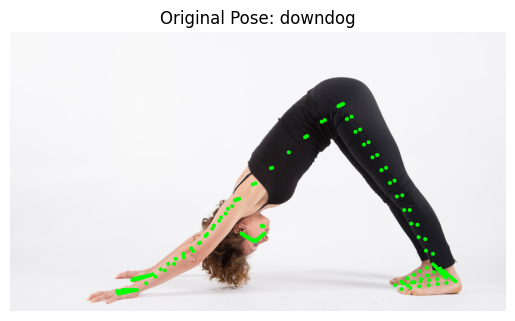

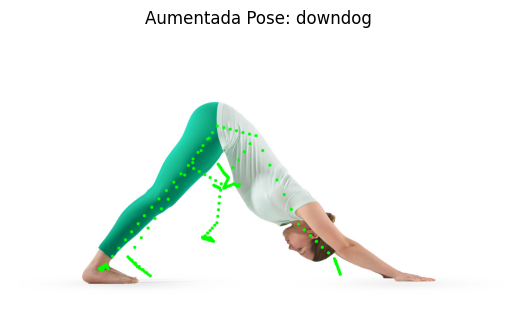

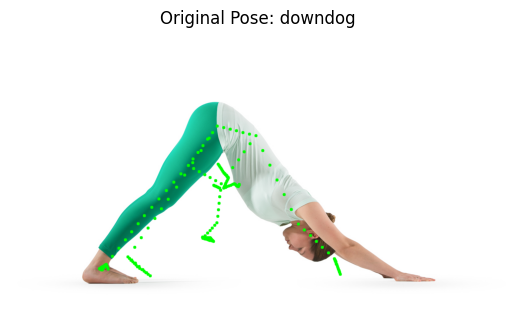

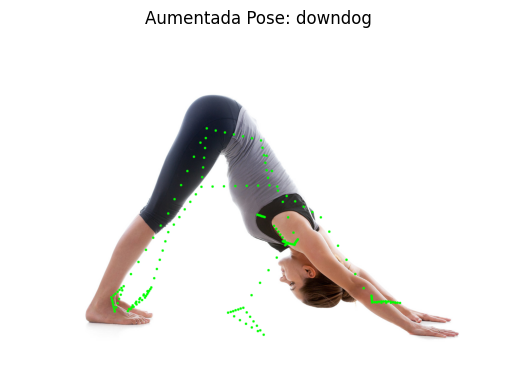

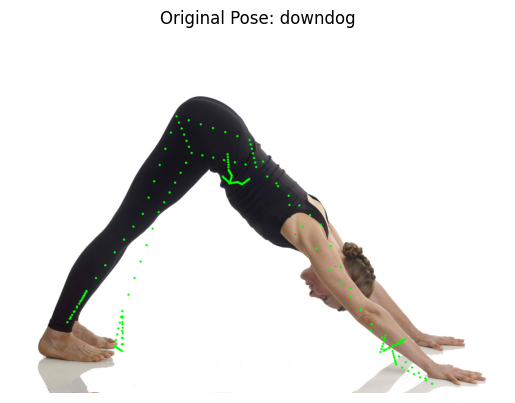

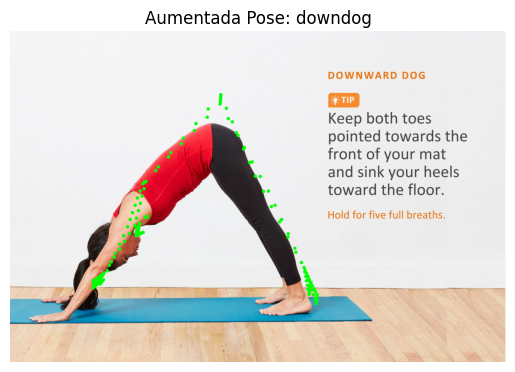

In [268]:
# Visualizar imágenes originales y aumentadas (flip horizontal)
for i in range(3):
    # Visualizar imagen original
    img_url = train_df.iloc[i]['url_img']
    keypoints = train_df.iloc[i]['keypoints']
    img = load_image_from_url(img_url)

    if img is not None:
        img_with_keypoints = visualize_keypoints_on_image(img.copy(), keypoints)
        plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
        plt.title(f"Original Pose: {train_df.iloc[i]['pose_name']}")
        plt.axis('off')
        plt.show()

    # Visualizar imagen aumentada (flip horizontal)
    augmented_img_url = augmented_train_df.iloc[i * 2 + 1]['url_img']  # Toma la imagen aumentada
    augmented_keypoints = augmented_train_df.iloc[i * 2 + 1]['keypoints']
    augmented_img = load_image_from_url(augmented_img_url)

    if augmented_img is not None:
        augmented_img_with_keypoints = visualize_keypoints_on_image(augmented_img.copy(), augmented_keypoints)
        plt.imshow(cv2.cvtColor(augmented_img_with_keypoints, cv2.COLOR_BGR2RGB))
        plt.title(f"Aumentada Pose: {augmented_train_df.iloc[i * 2 + 1]['pose_name']}")
        plt.axis('off')
        plt.show()


In [269]:
# Sobreescribir el DataFrame train_df con el DataFrame aumentado
train_df = augmented_train_df.copy()

# Verificar que el contenido se ha actualizado
print(f"Nuevo tamaño de train_df: {train_df.shape}")

Nuevo tamaño de train_df: (540, 3)


obtuvimos:
- Todas las clases con la misma cantidad de ejemplos.
- Las imágenes y keypoints invertidos estan reflejados correctamente en la salida visual.
- El DataFrame resultante (augmented_train_df) tiene tanto los ejemplos originales como los generados.

### Separación del conjunto de entrenamiento y prueba

- x_test_raw: Es la variable que almacenará las características del conjunto de prueba.
- y_test_raw: Es la variable que almacenará las etiquetas del conjunto de prueba.

In [270]:
# Para el conjunto de entrenamiento
x_train_raw = augmented_train_df['keypoints']  # Características (keypoints)
y_train_raw = train_df['pose_name']  # Etiquetas (pose_name)

# Para el conjunto de prueba
x_test_raw = test_df['keypoints']  # Características (keypoints)
y_test_raw = test_df['pose_name']  # Etiquetas (pose_name)

# Verifica las formas de las variables
print("train dataset: ", x_train_raw.shape, y_train_raw.shape)
print("test dataset: ", x_test_raw.shape, y_test_raw.shape)


train dataset:  (540,) (540,)
test dataset:  (970,) (970,)


In [271]:
# Codificar las clases
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']
le.fit(labels)
y_train_raw = le.transform(y_train_raw)
y_test_raw = le.transform(y_test_raw)


# dataset

Convertimos los datos de pose y etiquetas en tensores para PyTorch.

In [272]:
# Aplanar los datos de entrada
x_train_flat = np.array([np.array(kp).flatten() for kp in x_train_raw])
x_test_flat = np.array([np.array(kp).flatten() for kp in x_test_raw])

# Asegúrate de que las etiquetas sean arreglos NumPy y aplánalas (si corresponde)
y_train_flat = np.array([np.array(label).flatten() for label in y_train_raw])
y_test_flat = np.array([np.array(label).flatten() for label in y_test_raw])

# Verificar las formas resultantes
print("Forma de x_train_flat:", x_train_flat.shape)
print("Forma de y_train_flat:", y_train_flat.shape)
print("Forma de x_test_flat:", x_test_flat.shape)
print("Forma de y_test_flat:", y_test_flat.shape)


Forma de x_train_flat: (540, 624)
Forma de y_train_flat: (540, 1)
Forma de x_test_flat: (970, 624)
Forma de y_test_flat: (970, 1)


In [273]:

# Convertir a tensores
epochs = 10
batch_size = 128
lr = 0.01

x_train = torch.FloatTensor(x_train_flat)
y_train = torch.LongTensor(y_train_flat)
x_test = torch.FloatTensor(x_test_flat)
y_test = torch.LongTensor(y_test_flat)

In [274]:
input_shape = (33 * 3,)  # Cada muestra tiene 33 puntos clave con 3 coordenadas cada uno


In [275]:
assert len(x_train) == len(y_train), "x_train y y_train no coinciden en longitud"
assert len(x_test) == len(y_test), "x_test y y_test no coinciden en longitud"


### Creación de DataLoaders

- DataLoader es una clase de PyTorch que la vamos a usar para cargar y gestionar los datos de manera eficiente, creando iteradores para mini-batches, que es un subconjunto de datos que se utiliza para entrenar el modelo en una sola iteración, en lugar de usar todo el conjunto de datos.

In [276]:

# Combina las características (x) y etiquetas (y).
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)

# Crear iteradores para cargar los datos en mini-batches
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, drop_last=True, shuffle=True)


In [277]:
print("Clases aprendidas por el codificador:", le.classes_)
print("Etiquetas únicas en y_train_raw:", np.unique(y_train_raw))


Clases aprendidas por el codificador: ['downdog' 'goddess' 'plank' 'tree' 'warrior2']
Etiquetas únicas en y_train_raw: [0 1 2 3 4]


# model A

## probamos diferentes modelos

### primero

In [203]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Función para construir el modelo basado en keypoints
def build_keypoints_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    # Red neuronal densa (MLP)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(i)  # Más unidades y regularización L2
    x = Dropout(0.5)(x)  # Mayor Dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)  # Más unidades y regularización L2
    x = Dropout(0.5)(x)  # Mayor Dropout
    x = Dense(output_labels, activation='softmax')(x)

    return tf.keras.Model(inputs=[i], outputs=[x])



In [204]:
# Construir el modelo
model_keypoints = build_keypoints_model(input_shape, num_classes)

# Compilar el modelo
model_keypoints.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model_keypoints.summary()


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)          │ (None, 624)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 512)                 │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_21 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 452,613 (1.73 MB)

 Trainable params: 452,613 (1.73 MB)

 Non-trainable params: 0 (0.00 B)

In [205]:
# Entrenamiento del modelo
#EPOCHS = 30
EPOCHS = 200

history = model_keypoints.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=batch_size,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - accuracy: 0.2502 - loss: 10.5962 - val_accuracy: 0.4588 - val_loss: 9.5640
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3956 - loss: 9.5060 - val_accuracy: 0.5423 - val_loss: 8.6845
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.4206 - loss: 8.6451 - val_accuracy: 0.5557 - val_loss: 7.8914
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4870 - loss: 7.8171 - val_accuracy: 0.5588 - val_loss: 7.2127
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4694 - loss: 7.1342 - val_accuracy: 0.5495 - val_loss: 6.6046
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5346 - loss: 6.5031 - val_accuracy: 0.5876 - val_loss: 6.0448
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5313 - loss: 5.9709 - val_accuracy: 0.6113 - val_loss: 5.5394
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.5520 - loss: 5.4308 - val_accuracy: 0.5784 - val_loss

### modelo con menos epocas
**EL QUE MEJOR DIO**

In [278]:
# Función para construir el modelo basado en keypoints
def build_keypoints_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    # Red neuronal densa (MLP)
    x = Dense(128, activation='relu')(i)  # Más neuronas en la primera capa
    x = Dropout(0.3)(x)
    x = Dense(64, activation='relu')(x)   # Capa adicional con 64 neuronas
    x = Dropout(0.3)(x)
    x = Dense(output_labels, activation='softmax')(x)  # Capa de salida con softmax

    return Model(inputs=[i], outputs=[x])

# Definir forma de entrada y número de clases
input_shape = (len(x_train[0]),)  # Longitud de los keypoints
num_classes = len(le.classes_)  # Número de poses (etiquetas)



In [279]:
# Construir el modelo
model_keypoints = build_keypoints_model(input_shape, num_classes)

# Compilar el modelo
model_keypoints.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model_keypoints.summary()


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 624)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 128)                 │          80,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_45 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 88,581 (346.02 KB)

 Trainable params: 88,581 (346.02 KB)

 Non-trainable params: 0 (0.00 B)

In [280]:
# Entrenamiento del modelo
#EPOCHS = 30
EPOCHS = 100

history = model_keypoints.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=batch_size
)


Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - accuracy: 0.2471 - loss: 1.6340 - val_accuracy: 0.4773 - val_loss: 1.3911
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3867 - loss: 1.4070 - val_accuracy: 0.5577 - val_loss: 1.2579
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4611 - loss: 1.2857 - val_accuracy: 0.5763 - val_loss: 1.1860
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4764 - loss: 1.2082 - val_accuracy: 0.5773 - val_loss: 1.1346
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4937 - loss: 1.1759 - val_accuracy: 0.6072 - val_loss: 1.0992
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5661 - loss: 1.0988 - val_accuracy: 0.5742 - val_loss: 1.0769
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5650 - loss: 1.0564 - val_accuracy: 0.6515 - val_loss: 0.9946
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6028 - loss: 0.9733 - val_accuracy: 0.6546 - val_loss:

### Visualización de resultados

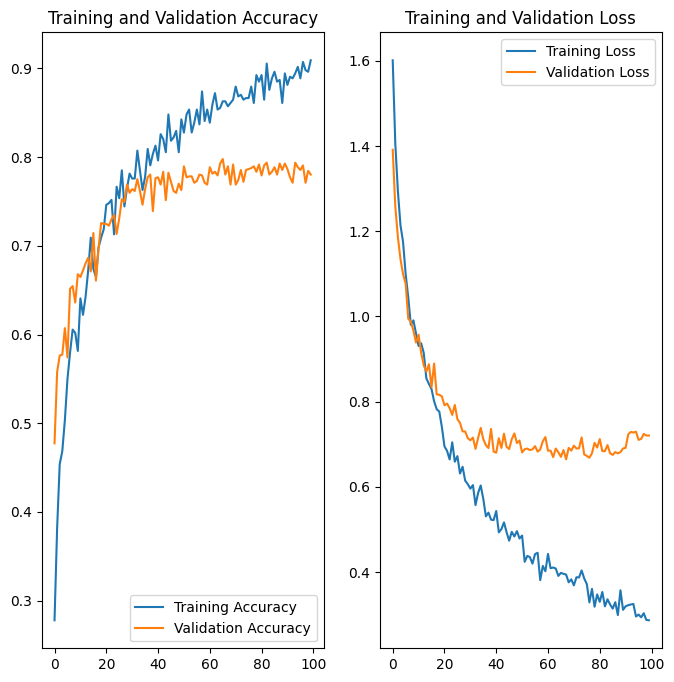

In [281]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### probando con mas capas y epocas

In [227]:
# Importar TensorFlow y otros módulos necesarios
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [228]:


# Función para construir el modelo basado en keypoints
def build_keypoints_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    # Red neuronal densa (MLP)
    x = Dense(256, activation='relu')(i)  # Más neuronas en la primera capa
    x = Dropout(0.3)(x)

    x = Dense(64, activation='relu')(x)   # Capa adicional con 64 neuronas
    x = Dropout(0.3)(x)
    x = Dense(output_labels, activation='softmax')(x)  # Capa de salida con softmax

    return Model(inputs=[i], outputs=[x])

# Definir forma de entrada y número de clases
input_shape = (len(x_train[0]),)  # Longitud de los keypoints
num_classes = len(le.classes_)  # Número de poses (etiquetas)



In [229]:
# Construir el modelo
model_keypoints = build_keypoints_model(input_shape, num_classes)

# Compilar el modelo
model_keypoints.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Resumen del modelo
model_keypoints.summary()


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 624)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_40 (Dense)                     │ (None, 256)                 │         160,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_41 (Dense)                     │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 176,773 (690.52 KB)

 Trainable params: 176,773 (690.52 KB)

 Non-trainable params: 0 (0.00 B)

In [230]:
# Entrenamiento del modelo
#EPOCHS = 30
EPOCHS = 200

history = model_keypoints.fit(
    x_train,
    y_train,
    validation_data=(x_test, y_test),
    epochs=EPOCHS,
    batch_size=batch_size
)


Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.2608 - loss: 1.6564 - val_accuracy: 0.4649 - val_loss: 1.3428
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4314 - loss: 1.3579 - val_accuracy: 0.5567 - val_loss: 1.1908
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4636 - loss: 1.2446 - val_accuracy: 0.5000 - val_loss: 1.1359
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5131 - loss: 1.1471 - val_accuracy: 0.6433 - val_loss: 1.0513
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4978 - loss: 1.0958 - val_accuracy: 0.5515 - val_loss: 1.0505
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5309 - loss: 1.0582 - val_accuracy: 0.6639 - val_loss: 1.0050
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5231 - loss: 1.0151 - val_accuracy: 0.6464 - val_loss: 0.9687
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5914 - loss: 0.9803 - val_accuracy: 0.6155 - val_loss:

dio peor que el anterior por lo que lo descartamos

### Visualización de resultados

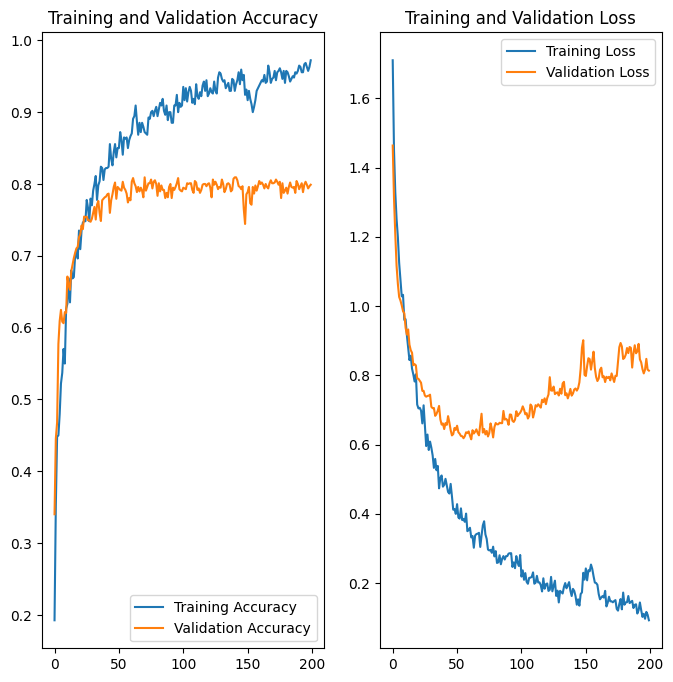

In [201]:
# Graficar precisión y pérdida
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


# PREDCICCION DE POSE DE YOGA

In [231]:
def predict_pose(image_path, model, label_encoder, expected_input_shape):
    """
    Predice la pose de yoga basada en una imagen y muestra la imagen con los keypoints superpuestos.

    Args:
        image_path (str): Ruta de la imagen a predecir.
        model (tf.keras.Model): Modelo entrenado para predecir poses de yoga.
        label_encoder (LabelEncoder): Codificador de etiquetas usado durante el entrenamiento.
        expected_input_shape (int): Tamaño esperado de la entrada del modelo.

    Returns:
        str: Nombre de la pose predicha.
    """
    # Cargar la imagen
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"No se pudo cargar la imagen desde la ruta: {image_path}")

    # Convertir la imagen a RGB para trabajar con MediaPipe y matplotlib
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Detectar keypoints usando MediaPipe
    with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
        results = pose.process(img_rgb)
        if not results.pose_landmarks:
            raise ValueError("No se detectaron keypoints en la imagen.")

        # Extraer los keypoints en un formato plano
        keypoints = [
            [landmark.x, landmark.y, landmark.z]
            for landmark in results.pose_landmarks.landmark
        ]
        keypoints_flat = np.array(keypoints).flatten()  # Aplanar los keypoints

    # Verificar la longitud de los keypoints y ajustar si es necesario
    if len(keypoints_flat) < expected_input_shape:
        # Rellenar con ceros si faltan valores
        keypoints_flat = np.pad(keypoints_flat, (0, expected_input_shape - len(keypoints_flat)), mode='constant')
    elif len(keypoints_flat) > expected_input_shape:
        # Truncar si hay demasiados valores
        keypoints_flat = keypoints_flat[:expected_input_shape]

    # Ajustar la forma para el modelo
    keypoints_flat = keypoints_flat.reshape(1, -1)

    # Realizar la predicción
    predictions = model.predict(keypoints_flat)
    predicted_label = np.argmax(predictions, axis=1)  # Índice de la clase predicha

    # Decodificar la etiqueta
    pose_name = label_encoder.inverse_transform(predicted_label)[0]

    # Dibujar keypoints y conexiones sobre la imagen
    img_with_keypoints = img_rgb.copy()
    mp_drawing.draw_landmarks(
        img_with_keypoints, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
        mp_drawing.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=3),
        mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=2)
    )

    # Visualizar la imagen procesada con keypoints
    plt.figure(figsize=(8, 8))
    plt.imshow(img_with_keypoints)
    plt.title(f"Pose predicha: {pose_name}", fontsize=16, color='blue')
    plt.axis('off')
    plt.show()

    return pose_name


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


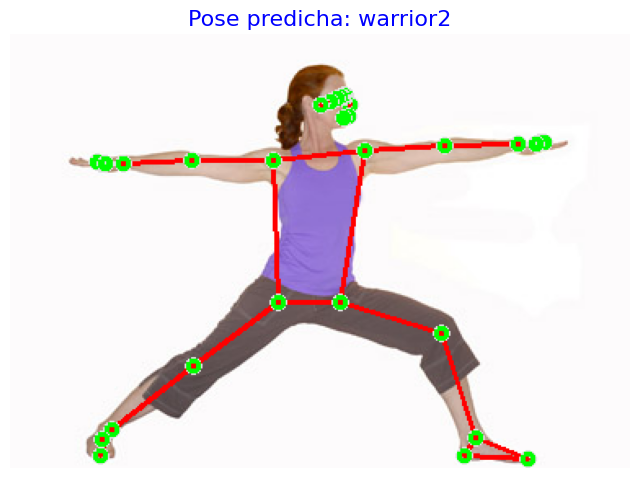

La pose predicha es: warrior2


In [232]:

# Ruta de una imagen de prueba
test_image_path = "/content/00000054.jpg"  # warrior2

# Predecir la pose
expected_shape = 624  # Ajustar según el modelo entrenado
predicted_pose = predict_pose(test_image_path, model_keypoints, le, expected_shape)

print(f"La pose predicha es: {predicted_pose}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


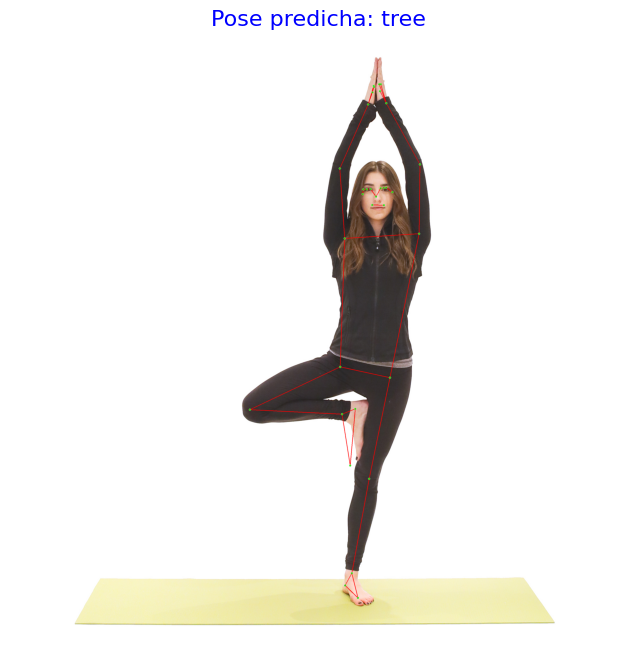

La pose predicha es: tree


In [233]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000032.jpg" #tree

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le, expected_shape)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


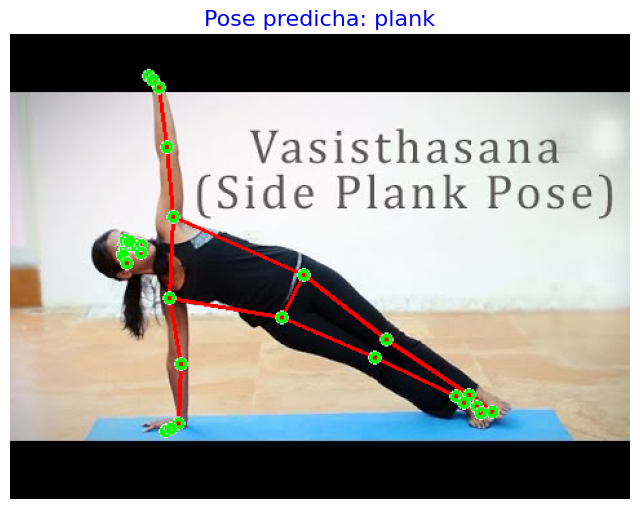

La pose predicha es: plank


In [234]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000122.jpg" #plank

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le, expected_shape)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


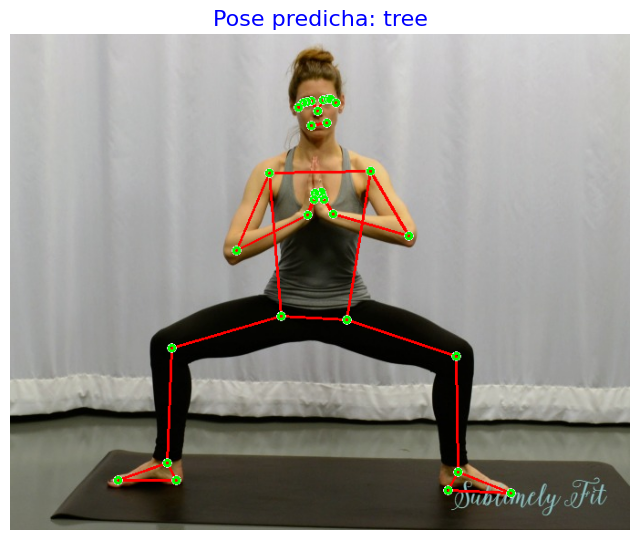

La pose predicha es: tree


In [235]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000084.jpg" #goddess

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le, expected_shape)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


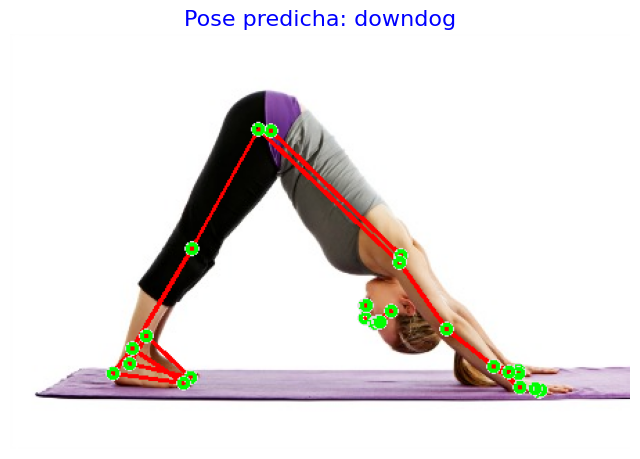

La pose predicha es: downdog


In [236]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000020.jpg" #downdog

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le, expected_shape)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


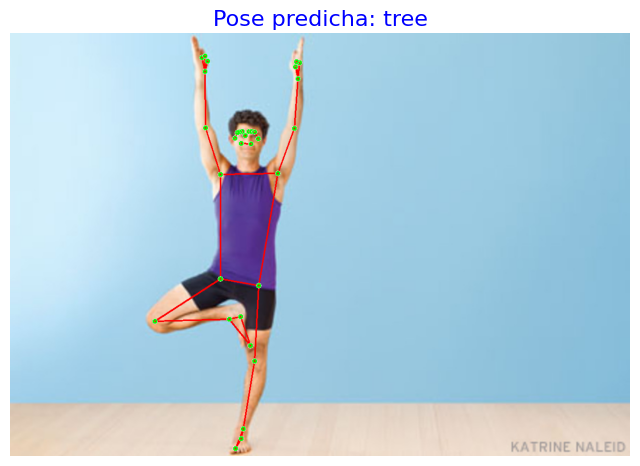

La pose predicha es: tree


In [237]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000050.jpg" #tree

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le, expected_shape)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


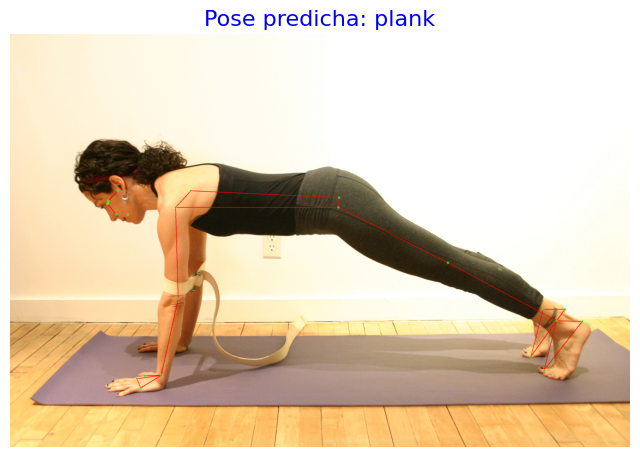

La pose predicha es: plank


In [238]:
# Ruta de una imagen de prueba
test_image_path = "/content/00000060.jpg" #plancha

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le, expected_shape)

print(f"La pose predicha es: {predicted_pose}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


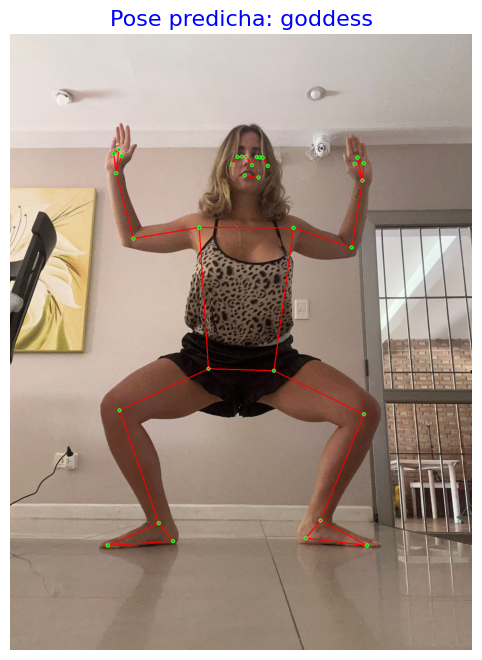

La pose predicha es: goddess


In [239]:
# Ruta de una imagen de prueba
test_image_path = "/content/IMG-20241206-WA0188.jpg" #goddess

# Predecir la pose
predicted_pose = predict_pose(test_image_path, model_keypoints, le, expected_shape)

print(f"La pose predicha es: {predicted_pose}")
